# Instance Segmentation with YOLO11

## Initialization
Inside **.venv/Scripts/activate** run: 
- pip install ultralytics

Link to model: https://docs.ultralytics.com/tasks/segment/
- I used **YOLO11m-seg**
- put it in /src

## Convert Annotations from JSON to YOLO & Split Into Train, Val, and Test Sets

Inside **.venv/Scripts/activate** run:

- pip install labelme2yolo
- labelme2yolo --json_dir </path/to/labelme_json_dir/> --val_size 0.15 --test_size 0.15 --output_format polygon --seed 42

*link to labelme2yolo: https://pypi.org/project/labelme2yolo/*

Also you need to **manually change** in the *(...)/YOLODataset/dataset.yaml* to the **correct path** *(which is the path to the folder (...)/YOLODataset)*, since the package doesn't do that for you

## Mask Bounding boxes
The point of this is to remove unnecessary stuff in the background that might conflict with the model training

### Visualize Bounding Boxes from the GP22 Model

In [11]:
import sys
import os
import cv2
import matplotlib.pyplot as plt

def draw_bounding_box(image_path, bounding_boxes):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    img_height, img_width = image.shape[:2]

    # Define the colors
    colors = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (255, 255, 0),
        4: (255, 0, 255),
        5: (0, 255, 255),
    }

    for bbox in bounding_boxes:
        class_id, x_center, y_center, width, height = bbox

        # Convert the coordinates to absolute values
        x_center, y_center = int(x_center * img_width), int(y_center * img_height)
        width, height = int(width * img_width), int(height * img_height)

        # Calculate the top-left and bottom-right corner of the bounding box
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        # Class color
        color = colors[class_id]

        # Draw the bounding box
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        # Add the class name
        cv2.putText(
            image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
        )

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

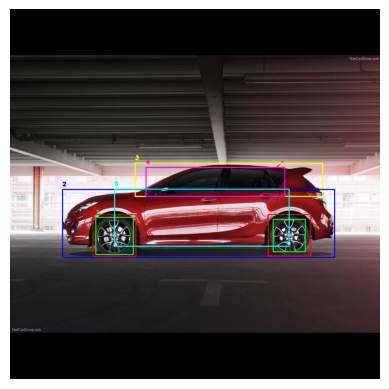

In [12]:
image_path = '../data/cropTest/images/C_Maz_05.jpeg'
image_label_path = '../data/cropTest/labels/C_Maz_05.txt'

bounding_boxes = []
with open(image_label_path, 'r') as file:
    for line in file:
        class_id, x_center, y_center, width, height = line.strip().split()
        bounding_boxes.append([int(class_id), float(x_center), float(y_center), float(width), float(height)])

draw_bounding_box(image_path, bounding_boxes)


### Mask bboxes

In [ ]:
import cv2
import numpy as np

def cropOutBackground(image_path, bounding_boxes):
    # Load your image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not read the image at {image_path}")

    # Get image dimensions
    img_height, img_width = image.shape[:2]

    # Create a blank mask with the same dimensions as the image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Draw white rectangles for each bounding box on the mask
    for (x_center, y_center, width, height) in bounding_boxes:
        # Convert normalized coordinates to pixel values
        x = int((x_center - width / 2) * img_width)
        y = int((y_center - height / 2) * img_height)
        w = int(width * img_width)
        h = int(height * img_height)

        # Draw the rectangle on the mask
        cv2.rectangle(mask, (x, y), (x + w, y + h), 255, thickness=-1)

    # Apply the mask to the image
    result = cv2.bitwise_and(image, image, mask=mask)

    # Save the result to disk
    cv2.imwrite('result.jpeg', result)
    print("Result saved successfully.")



In [2]:
image_path = '../data/cropTest/images/C_Maz_05.jpeg'
image_label_path = '../data/cropTest/labels/C_Maz_05.txt'

bounding_boxes = []
with open(image_label_path, 'r') as file:
    for line in file:
        class_id, x_center, y_center, width, height = line.strip().split()
        bounding_boxes.append([float(x_center), float(y_center), float(width), float(height)])

cropOutBackground(image_path, bounding_boxes)


Result saved successfully.


## Train Model

In [ ]:
from ultralytics import YOLO
import torch

# Set memory usage to 8 GB on a 16 GB GPU (50%)
#torch.cuda.set_per_process_memory_fraction(0.5, device=torch.device('cuda:0'))
torch.cuda.empty_cache()


model = YOLO("../src/yolo11m-seg.pt")

model.train(data= "../data/YOLODataset300/dataset.yaml", imgsz = 640, device = 0, batch = 8, epochs = 50, workers = 1)

New https://pypi.org/project/ultralytics/8.3.43 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.38  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=segment, mode=train, model=../src/yolo11m-seg.pt, data=../data/YOLODataset300/dataset.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=1, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed

train: Scanning C:\Users\mikae\Desktop\TRA235\data\YOLODataset300\labels\train.cache... 210 images, 0 backgrounds, 0 corrupt: 100%|██████████| 210/210 [00:00<?, ?it/s]
c:\Users\mikae\Desktop\TRA235\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\mikae\Desktop\TRA235\data\YOLODataset300\labels\val.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


Plotting labels to c:\Users\mikae\Desktop\TRA235\runs\segment\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 1 dataloader workers
Logging results to c:\Users\mikae\Desktop\TRA235\runs\segment\train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      13.3G      1.882      4.195      5.016      1.754          7       1024: 100%|██████████| 27/27 [22:54<00:00, 50.90s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:34<00:00, 11.64s/it]

                   all         45         87    0.00341      0.529    0.00268   0.000863    0.00274      0.425    0.00196   0.000531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      12.9G      1.637      2.236       3.23      1.633          9       1024: 100%|██████████| 27/27 [11:02<00:00, 24.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.38s/it]

                   all         45         87   0.000111     0.0115    7.5e-05    1.5e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.9G      1.777      1.815      2.253      1.878          3       1024: 100%|██████████| 27/27 [07:32<00:00, 16.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.43s/it]

                   all         45         87   0.000111     0.0115    7.5e-05    1.5e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      12.9G      1.845      1.814      2.255      1.929          3       1024: 100%|██████████| 27/27 [07:59<00:00, 17.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.46s/it]

                   all         45         87   0.000111     0.0115    7.5e-05    1.5e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.9G      1.679      1.591      1.869       1.76          6       1024: 100%|██████████| 27/27 [07:11<00:00, 15.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.15s/it]

                   all         45         87      0.216      0.159      0.061     0.0171      0.248      0.182     0.0793      0.024



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      12.8G      1.746      1.733      1.992      1.832         19       1024:  22%|██▏       | 6/27 [01:56<06:48, 19.46s/it]


KeyboardInterrupt: 

## Predict with Model
https://docs.ultralytics.com/modes/predict/#inference-arguments

In [7]:
%matplotlib inline


image 1/1 c:\Users\mikae\Desktop\TRA235\notebooks\..\data\rndmCar2.jpg: 320x640 2 windows, 66.4ms
Speed: 7.5ms preprocess, 66.4ms inference, 349.2ms postprocess per image at shape (1, 3, 320, 640)
Results saved to c:\Users\mikae\Desktop\TRA235\runs\segment\predict43
1 label saved to c:\Users\mikae\Desktop\TRA235\runs\segment\predict43\labels


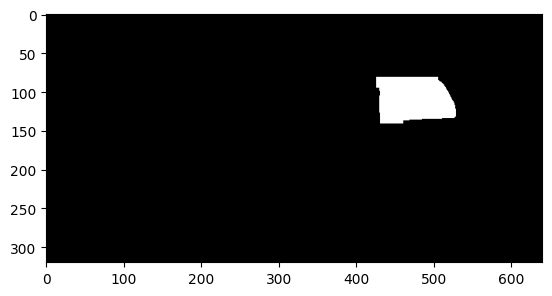

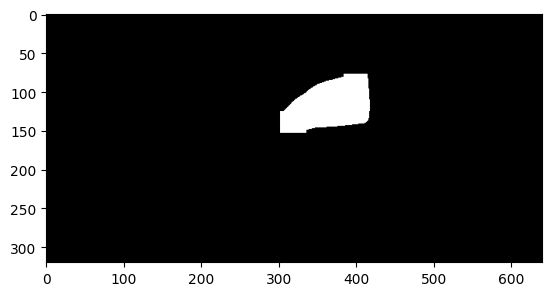

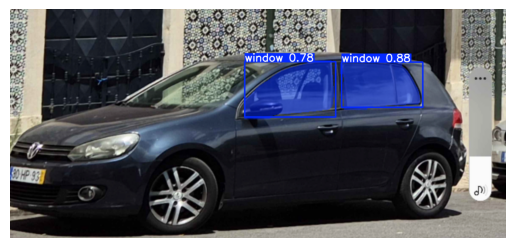

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

model = YOLO("../runs/segment/train5/weights/best.pt") # Path to model

results = model.predict(
    source="../data/rndmCar2.jpg", 
    show=True, 
    save=False, 
    conf=0.6, 
    line_width=1, 
    save_crop=True, 
    save_txt=True, 
    show_boxes=True, 
    show_labels=True, 
    show_conf=True, 
    classes=[0],
    iou=0.5  
)

masks = results[0].masks.data  



# Display every window:
for mask in masks:
    mask_np = mask.cpu().numpy()
    plt.imshow(mask_np, cmap="gray")  
    plt.show()

img_with_predictions = results[0].plot()
plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
